In [33]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import networkx as nx
from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares
from google.colab import drive
print(f"Running on PyMC v{pm.__version__}")
import os

Running on PyMC v5.20.1


In [ ]:
# Read epidemic incidence data
Data = pd.read_csv('Epidemic incidence data path')
Data = Data.to_numpy()

In [ ]:
# Read Laplacian Matrix data
df49 = pd.read_excel('Path to laplacian matrix')
names = df49.iloc[1:-1,0]
df47 = df49.iloc[1:-1,1:-1].fillna(0)
L = -df47.to_numpy()

In [ ]:
# Read population information
df_ll = pd.read_csv('Path to location-wise population information')
N = 0.001*df_ll.to_numpy() #N = 1000.0;
N = np.round(N)

# Networked SIR model

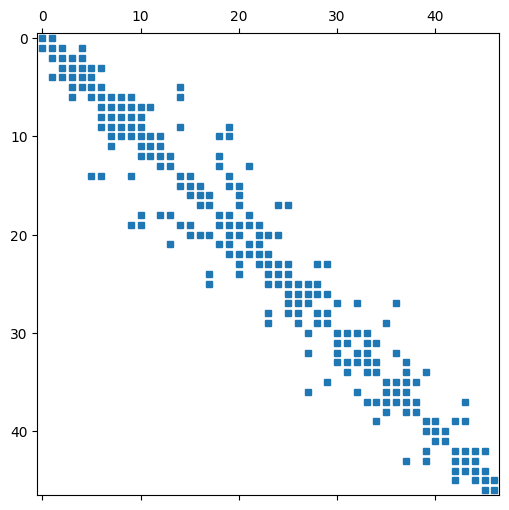

In [ ]:
# Visualize Laplacian matrix
plt.figure(figsize=(6,6))
plt.spy(L, markersize=5);
plt.show()

In [ ]:
n = 47 # specify the number of stations
dy = np.zeros((2*n))

In [ ]:
@njit
def matvec_mult(L, S):
    n, m = L.shape  # L is n x m
    result = np.empty(n)
    for i in range(n):
        sum = 0.0
        for j in range(m):
            sum += L[i, j] * S[j]
        result[i] = sum
    return result

In [ ]:
# define the right hand side of the ODE equations in the Scipy odeint signature
@njit
def rhs(X, t, theta):
    # unpack parameters
    S = X[0:n]
    I = X[n:2*n]
    # N = 1000.0;
    alpha, beta, gamma, mu, eps = theta
    # equations
    dy = np.empty(2*n)
    #LS = np.dot(L,S);
    #LI = np.dot(L,I);
    #S = S.reshape(-1,1); I = I.reshape(-1,1);
    dy[0:n] = mu*N - (beta*S*I)/(1+alpha*I) - mu*S - eps*matvec_mult(L,S)
    dy[n:2*n] = (beta*S*I)/(1+alpha*I) - (gamma+mu)*I - eps*matvec_mult(L,I)
    return dy

In [ ]:
# call Scipy's odeint function
# source_node = 13
# S0 = N*np.ones(n)
I0 = Data[0,:]#np.zeros(n)
#I0[source_node - 1] = 10.0;
S0 = N - I0 # assuminig initially recovery is zero
#S_I = odeint(func=rhs, y0=[S0, I0], t=time, args=(theta,))
init =np.concatenate([S0, I0])
#init
init

In [ ]:
time = np.linspace(0.0,214.0,215)
theta = np.array([0.5, 0.08, 0.26, 0.005, 0.05])
S_I = odeint(func=rhs, y0=init, t=time, args=(theta,));

In [ ]:
S_real = S_I[:, 0:n]; I_real = S_I[:,n:2*n]
I_real.shape

In [ ]:
%matplotlib inline
plt.plot(time, I_real);

In [ ]:
# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    dd = odeint(func=rhs, y0=init, t=time, args=(theta,))
    residuals = Data - dd[:,n:2*n]
    return residuals.flatten()

In [ ]:
lower_bounds = 5*[0] #make sure all parameters are positive
upper_bounds = [1.0, np.inf, np.inf, np.inf, np.inf]
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, x0=theta, bounds=(lower_bounds, upper_bounds));

In [ ]:
results.x

In [ ]:
# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = ["alpha", "beta", "gamma", "mu", "eps"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results.x
df.round(10)

In [ ]:
theta = results.x;
ls_SI = odeint(func=rhs, y0=init, t=time, args=(theta,))
ls_I = ls_SI[:,n:2*n]
plt.figure(figsize=(11,4))
plt.scatter(time, I_real[:,1])
plt.plot(time, ls_I[:,1])

In [ ]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=init, t=time, args=(theta,))[:,n:2*n]

In [ ]:
theta = results.x  # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    mu = pm.TruncatedNormal("mu", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    eps = pm.TruncatedNormal("eps", mu=theta[4], sigma=0.3, lower=0, initval=theta[4])
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([alpha, beta, gamma, mu, eps])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=Data)

In [ ]:
pm.model_to_graphviz(model=model)

In [ ]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]
vars_list

In [ ]:
# Specify the sampler
sampler = "NUTS Sampler"
tune = draws = 3000

# Inference!
with model:
    trace_nuts = pm.sample(tune=tune, draws=draws, chains=2,target_accept=0.9)#pm.sample(step=[pm.NUTS(vars_list)], tune=tune, draws=draws)
trace = trace_nuts
#az.summary(trace)

In [ ]:
az.summary(trace, round_to=10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.041429,0.001125,3.938303e-02,0.043586,1.451983e-04,1.031736e-04,60.439772,153.809011,1.038738
beta,0.000159,0.000005,1.501854e-04,0.000168,8.453000e-07,6.056000e-07,30.949181,115.336527,1.058329
eps,0.000003,0.000003,2.100000e-09,0.000007,3.930000e-08,2.780000e-08,3931.842183,3370.243331,1.000759
gamma,0.107220,0.001432,1.045015e-01,0.110043,1.212429e-04,8.591160e-05,139.512689,230.060226,1.026978
mu,0.000050,0.000050,6.500000e-09,0.000141,2.040100e-06,1.443300e-06,725.222374,1131.399279,1.003835
sigma,23.328697,0.163170,2.303145e+01,23.639320,3.797597e-03,2.685731e-03,1848.231499,3504.042367,1.000780


In [ ]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

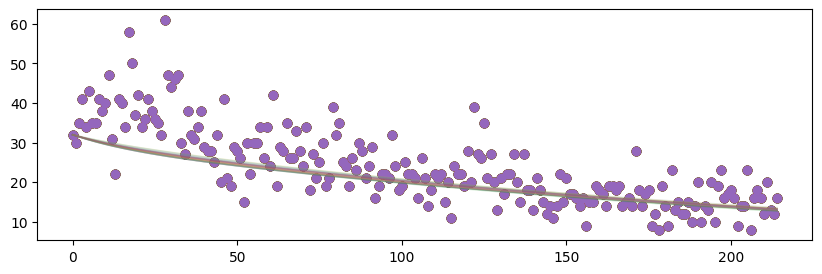

In [ ]:
num_samples = 25
node = 2
trace_df = az.extract(trace_nuts, num_samples=num_samples).to_dataframe()
plt.figure(figsize=(10,3));
for row_idx in range(num_samples):
  cols = ["alpha", "beta", "gamma", "mu", "eps"]
  row = trace_df.iloc[row_idx,:][cols].values
  theta = row;
  tm_SI = odeint(func=rhs, y0=init, t=time, args=(theta,))
  ls_I = tm_SI[:,n:2*n];  ls_I =  ls_I[:,node-1];
  plt.plot(time, ls_I,lw=1,alpha=0.2)
  plt.scatter(time, Data[:,node-1])

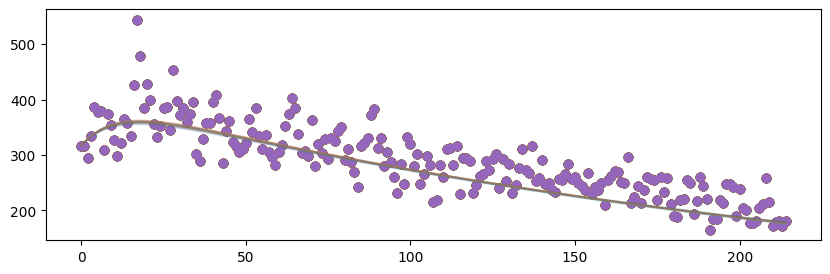

In [ ]:
num_samples = 25
node = 13
trace_df = az.extract(trace_nuts, num_samples=num_samples).to_dataframe()
plt.figure(figsize=(10,3));
for row_idx in range(num_samples):
  cols = ["alpha", "beta", "gamma", "mu", "eps"]
  row = trace_df.iloc[row_idx,:][cols].values
  theta = row;
  tm_SI = odeint(func=rhs, y0=init, t=time, args=(theta,))
  ls_I = tm_SI[:,n:2*n];  ls_I =  ls_I[:,node-1];
  plt.plot(time, ls_I,lw=1,alpha=0.2)
  plt.scatter(time, Data[:,node-1])

In [ ]:
est_theta = np.array([0.041429, 0.000159, 0.107220, 0.000050, 0.000003])
est_S_I = odeint(func=rhs, y0=init, t=time, args=(theta,));
Idata = est_S_I[:,n:2*n]
Idata.shape
dd = pd.DataFrame(Idata)
dd.shape
dd # Networked SIR model predicted Infected curve

# EGDL frameworks

In [ ]:
!pip install darts
import darts
from darts import TimeSeries
import numpy as np
from google.colab import files
import io
import matplotlib.pyplot as plt
from darts.models import NHiTSModel, TCNModel, NBEATSModel, TransformerModel
from darts.models import RNNModel
from darts import TimeSeries
from darts.utils.likelihood_models import GaussianLikelihood

## EGDL Parallel Approach

In [ ]:
# Load TB incidence data
data = pd.read_csv("TB incidence data path")
data.head()

In [ ]:
hor = 12 # Specify the forecast horizon
N = data.shape[0] - hor
train = data[:N]
test = data[N:]
test.shape
train_exo = dd[:N]

(9, 47)

In [ ]:
cases = TimeSeries.from_dataframe(train)

In [ ]:
cases = TimeSeries.from_dataframe(train)
cases_exo = TimeSeries.from_dataframe(train_exo)

In [ ]:
##################### EGP-NBeats ##########################
model_name = 'EGP-NBeats'
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs = 50, random_state=0)
model.fit(cases, past_covariates=cases_exo)
F1 = model.predict(hor)

In [ ]:
##################### EGP-Transformers #######################
model_name = "EGP-Transformers"
cases = TimeSeries.from_dataframe(train)
model = TransformerModel(input_chunk_length=24, output_chunk_length=12, n_epochs = 50, random_state=0)
model.fit(cases, past_covariates=cases_exo)
F1 = model.predict(hor)

In [ ]:
##################### EGP-TCN #######################
model_name = "EGP-TCN"
cases = TimeSeries.from_dataframe(train)
model = TCNModel(input_chunk_length=24, output_chunk_length=12, n_epochs = 50, random_state=0)
model.fit(cases, past_covariates=cases_exo)
F1 = model.predict(hor)

In [ ]:
##################### EGP-NHiTS #######################
model_name = "EGP-NHiTS"
cases = TimeSeries.from_dataframe(train)
model = NHiTSModel(input_chunk_length=24, output_chunk_length=12, n_epochs = 50, random_state=0)
model.fit(cases, past_covariates=cases_exo)
F1 = model.predict(hor)

## EGDL-Series Framework

In [ ]:
# Load TB incidence data
data = pd.read_csv("TB incidence data path")
data.head()

In [ ]:
hor = 12 # Specify the forecast horizon
N = data.shape[0] - hor
train = data[:N]
test = data[N:]
test.shape
train_exo = dd[:N]
test_exo = dd[N:]

In [ ]:
train_exo.columns = train.columns

In [ ]:
error_exo = train - train_exo

In [ ]:
cases_exo = TimeSeries.from_dataframe(error_exo)

In [ ]:
##################### EGS-NBEATS##########################
model_name = "EGS-NBEATS"
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs = 50, random_state=0)
model.fit(cases_exo)
F1 = model.predict(hor)
df=F1.pd_dataframe()
test_exo.columns = train.columns
df1 = df+test_exo

In [ ]:
##################### EGS-Transformers #######################
model_name = "EGS-Transformers"
model = TransformerModel(input_chunk_length=24, output_chunk_length=12, n_epochs = 50, random_state=0)
model.fit(cases_exo)
F1 = model.predict(hor)
df=F1.pd_dataframe()
test_exo.columns = train.columns
df1 = df+test_exo

In [ ]:
##################### EGS-TCN #######################
model_name = "EGS-TCN"
model = TCNModel(input_chunk_length=24, output_chunk_length=12, n_epochs = 50, random_state=0)
model.fit(cases_exo)
F1 = model.predict(hor)
df=F1.pd_dataframe()
test_exo.columns = train.columns
df1 = df+test_exo

In [ ]:
##################### EGS-NHiTS #######################
model_name = "EGS-NHiTS"
model = NHiTSModel(input_chunk_length=24, output_chunk_length=12, n_epochs = 50, random_state=0)
model.fit(cases_exo)
F1 = model.predict(hor)
df=F1.pd_dataframe()
test_exo.columns = train.columns
df1 = df+test_exo